<a href="https://colab.research.google.com/github/ofoofoo/bayesian-nn/blob/main/Uncertainty_Aware_Neural_Networks_Bayesian_NNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2023, [Themis AI, Inc.](https://themisai.io) All Rights Reserved.

In [1]:
from tqdm import tqdm
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np

from scipy.ndimage import rotate
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

#ThemisAI_Torch-BNN_Orion_Foo.ipynb

In [2]:
# Load the MNIST dataset
train_set = datasets.MNIST('./data', train=True, download=True)
test_set = datasets.MNIST('./data', train=False, download=True)

x_train, y_train = train_set.data/255., train_set.targets
x_test, y_test = test_set.data/255., test_set.targets
print(x_train.shape)
print(x_test.shape)

100%|██████████| 9912422/9912422 [00:00<00:00, 85356172.42it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 98165067.93it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 28820897.55it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20309732.16it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


Let's create a model using standard pytorch fully-connected (i.e., Linear) layers. These layers have two learnable parameters ($w$ and $b$), a nonlinear activation function $f(.)$, and implement the following foward pass with input $x$:
$$y = f(w^Tx + b)$$

Because the learnable parameters ($w$ and $b$) are deterministic scalar values, the resulting forward pass of the model is also entirely deterministic. Thus, we cannot estimate the uncertainty of such a model.

Let's start by training it on our dataset.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def create_model(LinearLayer):
  model = nn.Sequential(
      nn.Flatten(),
      LinearLayer(28*28, 128),
      nn.ReLU(),
      LinearLayer(128, 128),
      nn.ReLU(),
      LinearLayer(128, 10),
  )
  return model


def train(model, epochs=10, batch_size=32, lr=0.001):
  num_iters = x_train.shape[0] // batch_size
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  loss_fn = nn.CrossEntropyLoss()

  for epoch in range(epochs):
    model.train()
    for iter in range(num_iters):
      i_start = iter * batch_size
      x_batch = x_train[i_start : i_start+batch_size].to(device)
      y_batch = y_train[i_start : i_start+batch_size].to(device)
      #print(x_batch.shape)
      optimizer.zero_grad()
      y_pred = model(x_batch)
      loss = loss_fn(y_pred, y_batch)
      loss.backward()
      optimizer.step()

    model.eval()
    y_pred = model(x_test.to(device))
    print(y_pred.shape)
    cls_pred = y_pred.argmax(dim=1, keepdim=True).cpu().numpy()
    accuracy = np.mean(cls_pred[:,0] == y_test.numpy())
    print(f"epoch: {epoch}  ||  loss: {loss:.4f}  ||  acc: {100*accuracy:.2f}%")

  return model

In [4]:
# Create a model with vanilla keras Dense layers
base_model = create_model(LinearLayer=nn.Linear)
base_model.to(device)

# Train the base model!
base_model = train(base_model)

torch.Size([10000, 10])
epoch: 0  ||  loss: 0.0238  ||  acc: 95.25%
torch.Size([10000, 10])
epoch: 1  ||  loss: 0.0487  ||  acc: 96.19%
torch.Size([10000, 10])
epoch: 2  ||  loss: 0.0359  ||  acc: 96.87%
torch.Size([10000, 10])
epoch: 3  ||  loss: 0.0117  ||  acc: 96.85%
torch.Size([10000, 10])
epoch: 4  ||  loss: 0.0056  ||  acc: 96.31%
torch.Size([10000, 10])
epoch: 5  ||  loss: 0.0070  ||  acc: 97.14%
torch.Size([10000, 10])
epoch: 6  ||  loss: 0.0217  ||  acc: 97.01%
torch.Size([10000, 10])
epoch: 7  ||  loss: 0.0003  ||  acc: 97.72%
torch.Size([10000, 10])
epoch: 8  ||  loss: 0.0002  ||  acc: 97.80%
torch.Size([10000, 10])
epoch: 9  ||  loss: 0.0001  ||  acc: 97.70%


Let's now create a new (custom) Linear layer that we can use to learn a probaility distribution for every weight in the neural network. An example of building a custom layer in pytorch is shown [here](https://pytorch.org/tutorials/beginner/examples_nn/polynomial_module.html).

Instead of modeling every weight in our neural network with a single scalar value, let's treat every weight as a full probability distribution (e.g., a Normal distribution):
$$ w \sim \mathcal N(\mu, \sigma^2)$$

This means that instead of our neural network learning a set of deterministic scalars during training, we will now train the model to learn a set of probability distributions (where every individual weight is a probability distribution).

There are two key changes this will require in our model:
### 1. Training:
It is not possible to backpropogate through probability distributions, thus a common solution is to leverage the "reparameterization trick" ([explaination here](https://stats.stackexchange.com/questions/199605/how-does-the-reparameterization-trick-for-vaes-work-and-why-is-it-important/205336#205336)). In summary, during model training, we now need to sample a set of deterministic weights from our probabilistic weights, this can be done by sampling from a stochastic normal distribution ($\epsilon \sim \mathcal N(0,1)$) and applying the reparameterization trick on our learnable parameters:
$$ w = \mu + \epsilon \cdot \sigma$$

### 2. Testing:
During testing we want to be able to leverage the fact that our neural network weights are now probabilistic to be able to estimate the uncertainty of our model on any new input. We can do this by sampling from the model multiple times, and computing the mean and standard deviation of the predicted outputs. Intuitively, if these outputs are all in strong agreement with each other it is a strong indicator that the model is confident about its prediction (and inversely, if the model is largely disagreeing with itself, it indicates high amounts of uncertainty).


In [5]:
class LinearBayesian(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out # MNIST: flattened 784 1D tensor input

        """ TODO: define the learnable parameters of this layer """
        self.mu_w = nn.Parameter(torch.Tensor(size_out, size_in)) # should be mu @ x where x is a flattened 28x28 = 784
        self.sigma_w = nn.Parameter(torch.Tensor(size_out, size_in))
        self.mu_b = nn.Parameter(torch.Tensor(size_out))
        self.sigma_b = nn.Parameter(torch.Tensor(size_out))

        """ TODO: initialize these parameters """
        # Kaiming initialization because optimized for ReLU networks
        nn.init.kaiming_uniform_(self.mu_w, a=math.sqrt(5))
        nn.init.constant_(self.sigma_w, -5)  # Initializing sigma such that variance in each layer is small initially
        nn.init.zeros_(self.mu_b)
        nn.init.constant_(self.sigma_b, -5)

    def forward(self, x):
        """ TODO: define the forward pass of this layer
            1. Apply the reparameterization trick to sample weights
            2. Compute a forward pass of the model
        """
        # Reparameterization trick to sample weights and biases: sample epsilon from N(0, 1) and then find mu + sigma * epsilon
        weight_epsilon = torch.normal(0, 1, size=(self.size_out, self.size_in)).to(x.device)
        bias_epsilon = torch.normal(0, 1, size=(self.size_out,)).to(x.device)

        weight_sigma = torch.log1p(torch.exp(self.sigma_w))
        bias_sigma = torch.log1p(torch.exp(self.sigma_b))

        weight = self.mu_w + weight_sigma * weight_epsilon
        bias = self.mu_b + bias_sigma * bias_epsilon

        # Forward pass using the sampled weights and bias
        output = torch.addmm(bias, x, weight.t())
        return output


Now using our newly created Bayesian Dense layers let's use them to create a new model and train it!



In [6]:
# Create a new model now using our custom Dense Bayesian layers
model = create_model(LinearLayer=LinearBayesian)
model.to(device)

# ... and train it!
model = train(model)
model

torch.Size([10000, 10])
epoch: 0  ||  loss: 0.0262  ||  acc: 94.39%
torch.Size([10000, 10])
epoch: 1  ||  loss: 0.0276  ||  acc: 96.32%
torch.Size([10000, 10])
epoch: 2  ||  loss: 0.0262  ||  acc: 96.40%
torch.Size([10000, 10])
epoch: 3  ||  loss: 0.0066  ||  acc: 96.91%
torch.Size([10000, 10])
epoch: 4  ||  loss: 0.0025  ||  acc: 97.30%
torch.Size([10000, 10])
epoch: 5  ||  loss: 0.0010  ||  acc: 97.44%
torch.Size([10000, 10])
epoch: 6  ||  loss: 0.0030  ||  acc: 97.32%
torch.Size([10000, 10])
epoch: 7  ||  loss: 0.0001  ||  acc: 97.44%
torch.Size([10000, 10])
epoch: 8  ||  loss: 0.0010  ||  acc: 97.62%
torch.Size([10000, 10])
epoch: 9  ||  loss: 0.0003  ||  acc: 97.53%


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): LinearBayesian()
  (2): ReLU()
  (3): LinearBayesian()
  (4): ReLU()
  (5): LinearBayesian()
)

We now have trained a Bayesian NN that "knows what it does not know"!

Let's use it to make some predictions and detect its failures on challenging datapoints and out-of-distribution (OOD) data.

In [7]:
def predict_with_uncertainty(model, inputs, num_stochastic_samples=10):
  """ Stochastically samples multiple forward passes through the network and
  compute the prediction and uncertainty of the model by taking the mean and
  standard deviation (respectively) over the sampled outputs. Remember to pass
  the sampled logits through a softmax before computing the mean and std.

  Returns a tuple of the estimated prediction (mean) and uncertainty (std)
  over the predicted probabilities. """
  model.eval()
  print(inputs.shape)
  with torch.no_grad():  # Disable gradient computation
      """ TODO: evaluate `num_stochastic_samples` forward passes through the model """
      outputs = [F.softmax(model(inputs).cpu(), dim=1) for _ in range(num_stochastic_samples)] # compute softmax over ROWS of inputs tensor
      outputs = torch.stack(outputs)  # Shape: [num_stochastic_samples, batch_size, num_classes]
      #print(torch.mean(outputs, dim=0).shape)
      #print(torch.std(outputs, dim=0).shape)
      """ TODO: compute the final prediction """
      prediction = tuple(torch.mean(outputs, dim = 0).tolist())  # Mean over samples; Shape: [batch_size, num_classes]
      """ TODO: compute the final uncertainty """
      uncertainty = tuple(torch.std(outputs, dim = 0).tolist())  # Standard deviation; Shape: [batch_size, num_classes]

  return prediction, uncertainty

In [8]:
## Run predictions on the test set and compute uncertainty
y_test_pred, y_test_unc = predict_with_uncertainty(model, x_test.to(device), num_stochastic_samples=10)

y_test_pred = np.mean(y_test_pred, axis = 1)
y_test_unc = np.mean(y_test_unc, axis = 1)

inds_sorted_by_unc = np.argsort(y_test_unc)

torch.Size([10000, 28, 28])


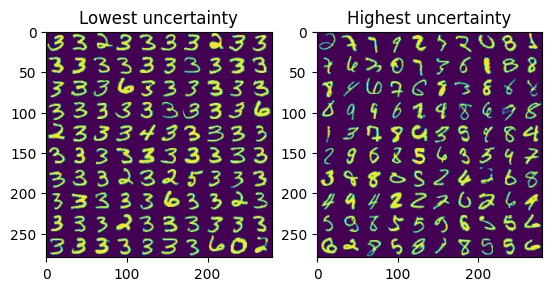

In [9]:
## Plot the top 25 most confident images and top-25 most uncertainty images in the test set
def plot_grid(images, rsize=10, csize=10):
  """ Plots images in a grid of size (rsize, csize) """
  assert len(images) == rsize * csize
  k = 0
  grid = []
  for i in range(rsize):
    row = []
    for j in range(csize):
      row.append(images[k])
      k += 1
    grid.append(np.hstack(row))
  return np.vstack(grid)


fig, ax = plt.subplots(1, 2)
ax[0].imshow(plot_grid(x_test[inds_sorted_by_unc[:100]])); ax[0].set_title("Lowest uncertainty");
ax[1].imshow(plot_grid(x_test[inds_sorted_by_unc[-100:]])); ax[1].set_title("Highest uncertainty");

We can further understand the utility of uncertainty estimation by observing the model's uncertianty on datapoints that have never been seen before during training (these should have very high uncertainty, and high likelihood of model failure).

Let's try it out by rotating a certain type of digit in the dataset clockwise from 0 to 360 degrees around in a circle. At each rotation step we can compute the model's prediction and uncertainty.


In [10]:
# Some helper functions for building visualizations (can be ignored)
def rotate_img(image, steps=None, n=15):
  """ Rotates an image by degree step amounts and returns:

  rotated_imgs: list of rotated images by step amounts
  subset_imgs: a subset list of length `n` images (for visualization)
  """
  if steps is None:
    steps = range(0, 360, 1) # rotate from 0 - 360 degrees

  rotated_imgs = [rotate(image, angle, reshape=False, order=1) for angle in steps]
  display_inds = np.floor(np.linspace(0, len(steps)-1, n)).astype(int)
  subset_imgs = np.stack([rotated_imgs[i] for i in display_inds], axis=0)
  return steps, rotated_imgs, subset_imgs

def find_images_with_label(images, labels, desired_label):
  """ Filters images according to a those that have a desired class label """
  inds = np.where(labels==desired_label)[0]
  return images[inds]

def normalize(x):
  """ Normalizes an array to [0, 1] bounds """
  return (x-x.min()) / (x.max()-x.min())

# Extension 0: Comparison between the performance of the BNN on all digits adversarially

Fetching 500 images of the digit "0" and rotating them for OOD testing


100%|██████████| 500/500 [00:21<00:00, 23.45it/s]


Visualizing the network predictions and uncertainties
torch.Size([180000, 28, 28])
torch.Size([180000, 28, 28])
180000
10
500
Fetching 500 images of the digit "1" and rotating them for OOD testing


100%|██████████| 500/500 [00:20<00:00, 23.83it/s]


Visualizing the network predictions and uncertainties
torch.Size([180000, 28, 28])
torch.Size([180000, 28, 28])
180000
10
500
Fetching 500 images of the digit "2" and rotating them for OOD testing


100%|██████████| 500/500 [00:21<00:00, 22.99it/s]


Visualizing the network predictions and uncertainties
torch.Size([180000, 28, 28])
torch.Size([180000, 28, 28])
180000
10
500
Fetching 500 images of the digit "3" and rotating them for OOD testing


100%|██████████| 500/500 [00:22<00:00, 22.10it/s]


Visualizing the network predictions and uncertainties
torch.Size([180000, 28, 28])
torch.Size([180000, 28, 28])
180000
10
500
Fetching 500 images of the digit "4" and rotating them for OOD testing


100%|██████████| 500/500 [00:19<00:00, 25.29it/s]


Visualizing the network predictions and uncertainties
torch.Size([180000, 28, 28])
torch.Size([180000, 28, 28])
180000
10
500
Fetching 500 images of the digit "5" and rotating them for OOD testing


100%|██████████| 500/500 [00:20<00:00, 23.89it/s]


Visualizing the network predictions and uncertainties
torch.Size([180000, 28, 28])
torch.Size([180000, 28, 28])
180000
10
500
Fetching 500 images of the digit "6" and rotating them for OOD testing


100%|██████████| 500/500 [00:22<00:00, 22.21it/s]


Visualizing the network predictions and uncertainties
torch.Size([180000, 28, 28])
torch.Size([180000, 28, 28])
180000
10
500
Fetching 500 images of the digit "7" and rotating them for OOD testing


100%|██████████| 500/500 [00:21<00:00, 23.10it/s]


Visualizing the network predictions and uncertainties
torch.Size([180000, 28, 28])
torch.Size([180000, 28, 28])
180000
10
500
Fetching 500 images of the digit "8" and rotating them for OOD testing


100%|██████████| 500/500 [00:21<00:00, 23.02it/s]


Visualizing the network predictions and uncertainties
torch.Size([180000, 28, 28])
torch.Size([180000, 28, 28])
180000
10
500
Fetching 500 images of the digit "9" and rotating them for OOD testing


100%|██████████| 500/500 [00:30<00:00, 16.21it/s]


Visualizing the network predictions and uncertainties
torch.Size([180000, 28, 28])
torch.Size([180000, 28, 28])
180000
10
500


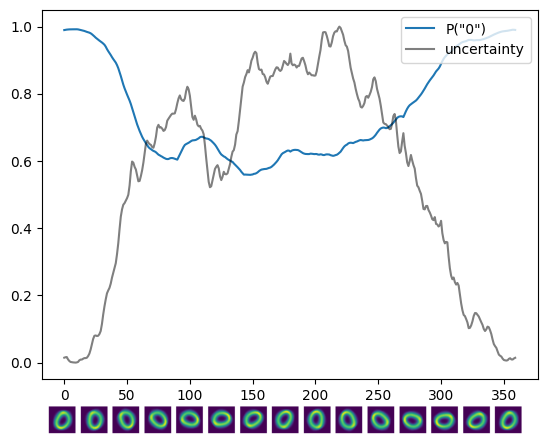

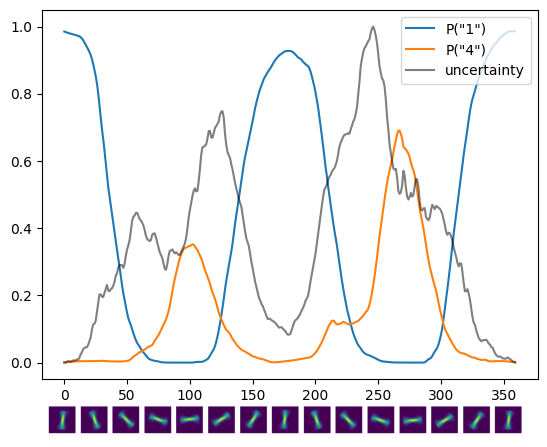

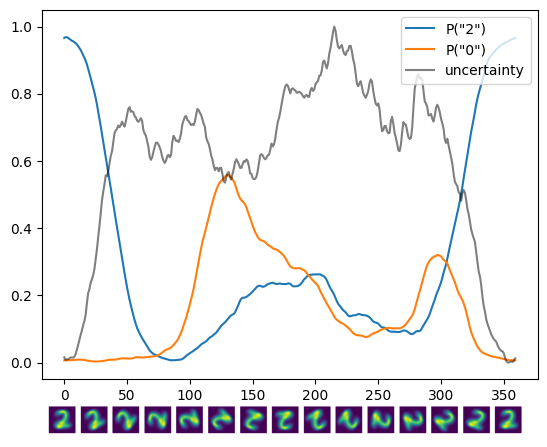

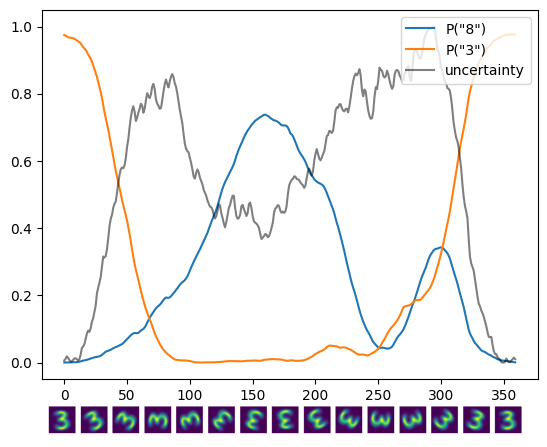

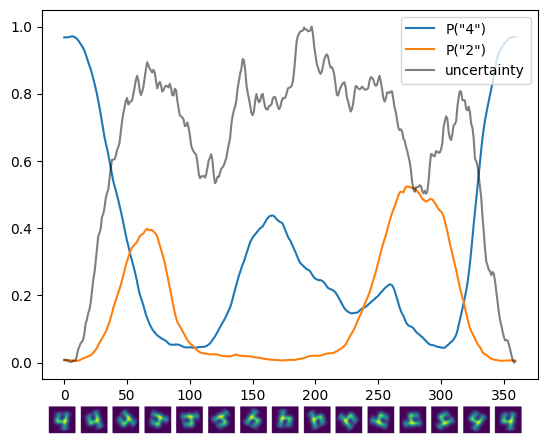

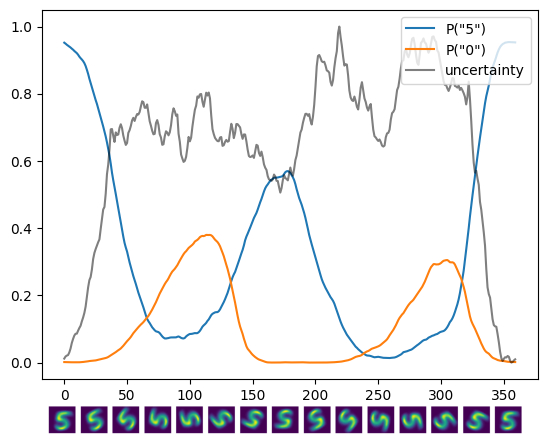

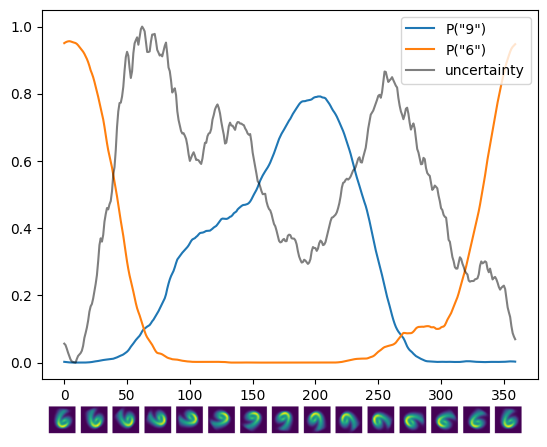

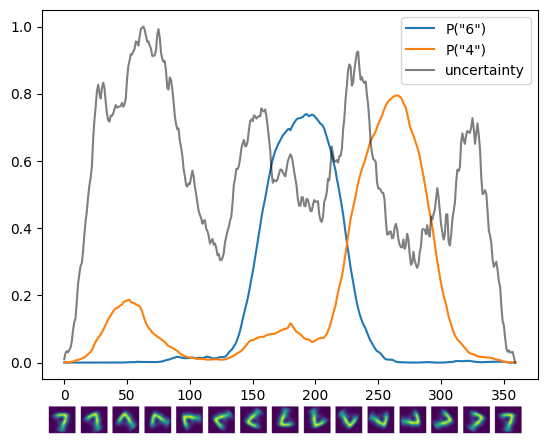

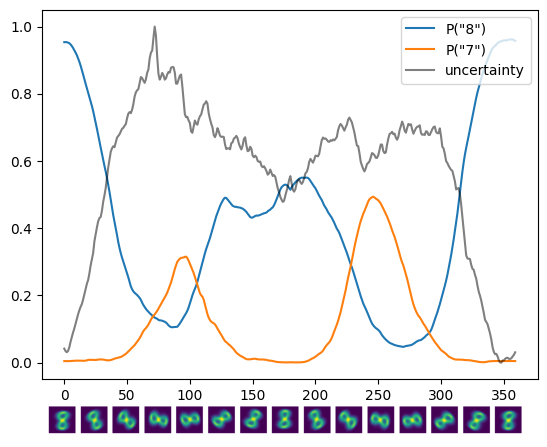

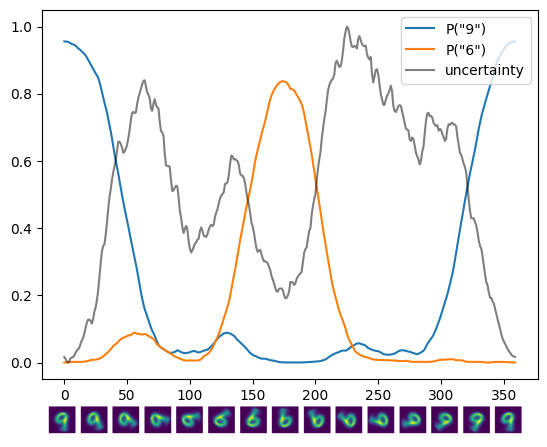

In [11]:
for i in range(10):
  desired_label = i  # The desired class label to rotate
  num_images = 500  # How many images from this class to test on

  print(f"Fetching {num_images} images of the digit \"{desired_label}\" " +
        "and rotating them for OOD testing")
  images_of_ones = find_images_with_label(x_test, y_test, desired_label)
  images_of_ones = images_of_ones[:num_images]

  steps, rotations, grids = zip(*[rotate_img(img) for img in tqdm(images_of_ones)])
  steps = steps[0] # shape: (rotation_steps, )
  rotations = np.array(rotations)  # shape: (num_imgs, rotation_steps, height, width)
  grid = np.mean(grids, 0)  # shape: (sub_rotation_steps, height, width)


  print("Visualizing the network predictions and uncertainties")
  ## 1. Visualize the inference data (i.e., rotation images)
  fig = plt.figure(figsize=(16, 10))
  for i in range(grid.shape[0]):
      ax = fig.add_subplot(1, grid.shape[0], i+1)
      plt.imshow(grid[i])
      ax.set_axis_off()
  plt.savefig('/content/inference_data.png', bbox_inches='tight')
  plt.close()

  ## 2. Compute the model predictions
  num_imgs, rotation_steps, height, width = rotations.shape
  inputs = torch.from_numpy(rotations.reshape(-1, height, width)).to(device)
  print(inputs.shape)
  pred, unc = predict_with_uncertainty(model, inputs)
  print(len(unc))
  print(len(unc[0]))
  print(num_imgs)
  pred, unc = [arr.reshape(num_imgs, rotation_steps, -1).mean(0) for arr in (np.array(pred), np.array(unc))]
  unc = np.mean(unc, axis = 1)

## 3. Visualize the model predictions
  fig, ax = plt.subplots()
  cls, counts = np.unique(pred.argmax(1), return_counts=True)
  top_2_classes = cls[np.argsort(counts)[-2:]][::-1]
  for cls in top_2_classes:
    plt.plot(steps, pred[:, cls], label=f"P(\"{cls}\")")
  plt.plot(steps, normalize(unc), '-k', label="uncertainty", alpha = 0.5) # Note that uncertainty here is NORMALIZED, hence the large values for labels that perform well such as "0"
  plt.legend(loc="upper right")

  im = mpimg.imread('/content/inference_data.png')
  newax = fig.add_axes([0.13, -0.01, 0.75, 6], anchor='S', zorder=1)
  newax.imshow(im)
  newax.axis('off');

# Let's get creative!

Go beyond this and extend your findings even further! Pick one of the following possible extensions (or something entirely new):

1. Test your Bayesian MNIST model on another creative test set (e.g., different datasets, adversarial examples, etc.);
2. Try your bayesian layer implementation on a different learning problem (e.g., a harder image dataset, or new task such as next-word prediction)
3. Training on continuous regression problems (e.g., MSE loss) rather than classification problems (e.g., cross entropy loss);
4. Extending your bayesian layer implementations to other layers (e.g., Convolutional layers, recurrent layers, etc)


# Extension 1: Testing model performance on other adversarial examples

In [12]:
!pip install foolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.0 MB/s eta 0:00:00


torch.Size([10000, 28, 28])


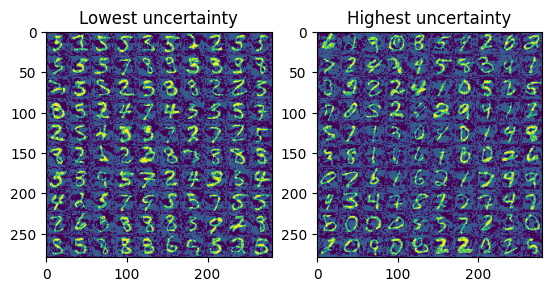

In [13]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import foolbox as fb

transform = transforms.Compose([transforms.ToTensor()])
mnist_testset_test = MNIST(root='./data', train=False, download=True, transform=transform)
mnist_testset_train = MNIST(root='./data', train=True, download=True, transform=transform)

test_loader = DataLoader(mnist_testset_test, batch_size=64, shuffle=False)
train_loader = DataLoader(mnist_testset_train, batch_size=64, shuffle=False)

fmodel = fb.PyTorchModel(model, bounds=(0, 1)) # Foolbox model with bounds 0, 1

attack = fb.attacks.LinfFastGradientAttack() # FGSM Attack

def generate_adversarial_examples(data_loader_test, data_loader_train, attack, fmodel, epsilon):
    adv_examples_test = []
    for data, target in data_loader_test:
        data, target = data.to(fmodel.device), target.to(fmodel.device)
        _, adv_data, _ = attack(fmodel, data, target, epsilons=epsilon)
        adv_data = adv_data.squeeze(0)
        target = target.squeeze()
        adv_examples_test.append((adv_data, target))
    adv_examples_train = []
    for data, target in data_loader_train:
        data, target = data.to(fmodel.device), target.to(fmodel.device)
        _, adv_data, _ = attack(fmodel, data, target, epsilons=epsilon)
        adv_data = adv_data.squeeze(0)
        target = target.squeeze()
        adv_examples_train.append((adv_data, target))

    return adv_examples_test, adv_examples_train

def concatenate_adv_examples(adv_examples):
    # Concatenate all adversarial examples and their labels
    all_adv_data = torch.cat([batch[0] for batch in adv_examples])
    all_adv_labels = torch.cat([batch[1] for batch in adv_examples])
    return all_adv_data, all_adv_labels

# Generate adversarial examples
adv_examples_test, adv_examples_train = generate_adversarial_examples(test_loader, train_loader, attack, fmodel, 0.3)
all_adv_data, all_adv_labels = concatenate_adv_examples(adv_examples_test)
all_adv_data_train, all_adv_labels_train = concatenate_adv_examples(adv_examples_train)

all_adv_data_train = all_adv_data_train.squeeze().cpu()
all_adv_labels_train = all_adv_labels_train.cpu()

all_adv_data = all_adv_data.squeeze().cpu()
all_adv_labels = all_adv_labels.cpu()

# Run predictions on the test set and compute uncertainty
y_test_pred, y_test_unc = predict_with_uncertainty(model, all_adv_data.to(device), num_stochastic_samples=10)

y_test_pred = np.mean(y_test_pred, axis = 1)
y_test_unc = np.mean(y_test_unc, axis = 1)

inds_sorted_by_unc = np.argsort(y_test_unc)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(plot_grid(all_adv_data[inds_sorted_by_unc[:100]])); ax[0].set_title("Lowest uncertainty");
ax[1].imshow(plot_grid(all_adv_data[inds_sorted_by_unc[-100:]])); ax[1].set_title("Highest uncertainty");

# Visualizing Generated Adversarial Data

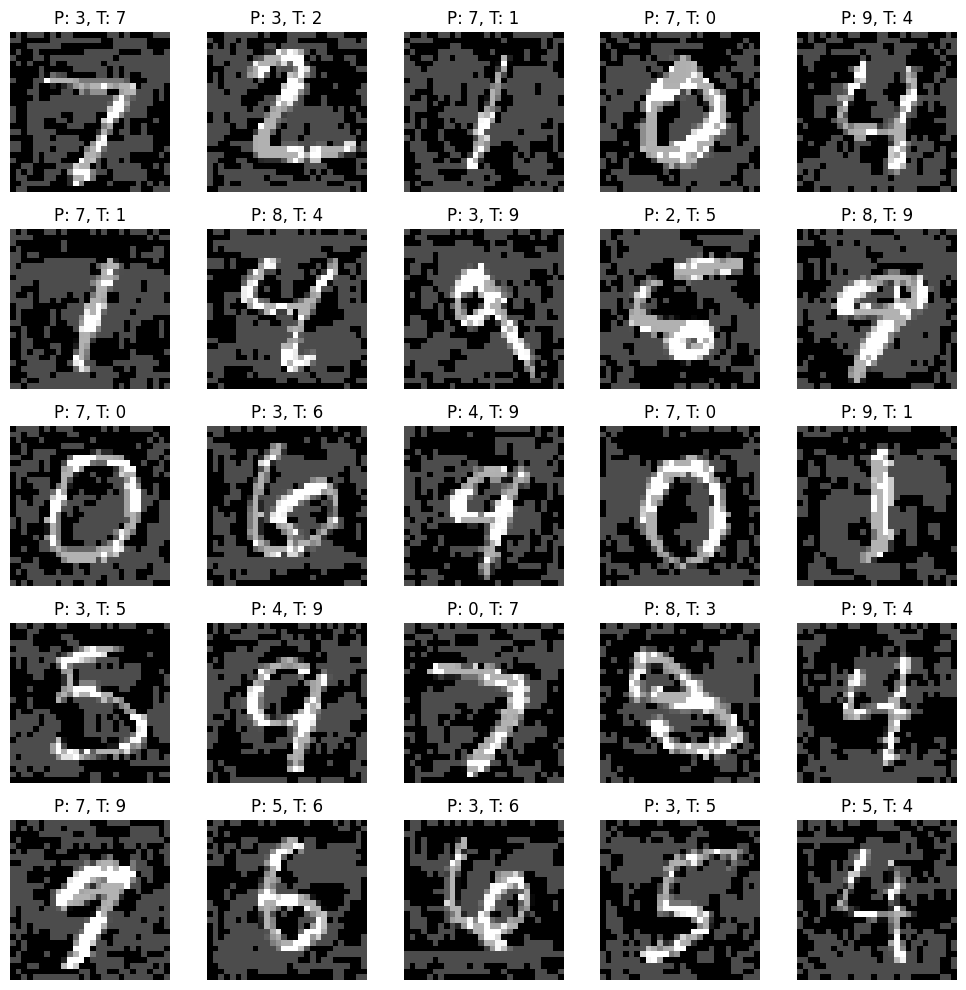

In [14]:
def plot_adversarial_images(images, titles=None, rows=5, cols=5, figsize=(10, 10)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        img = images[i].cpu().numpy().squeeze()
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        if titles is not None:
            ax.set_title(titles[i])

    plt.tight_layout()
    plt.show()

num_images_to_plot = 25
subset_adv_images = all_adv_data[:num_images_to_plot]

_, predicted_labels = torch.max(model(subset_adv_images.to(device)), 1)
titles = [f'P: {p.item()}, T: {t.item()}' for p, t in zip(predicted_labels, all_adv_labels[:num_images_to_plot])]


plot_adversarial_images(subset_adv_images, titles=titles)

In [15]:
_, predicted_labels = torch.max(model(all_adv_data.to(device)), 1)
num_correct = 0
for x, y in zip(predicted_labels, all_adv_labels):
  if x == y:
    num_correct += 1
print(f'Accuracy on adversarial testing set without training: {(num_correct / len(all_adv_data)) * 100}%')

Accuracy on adversarial testing set without training: 1.58%


# Extension 2: Training on Adversarial Data

In [16]:
x_adv_train = torch.cat((all_adv_data_train, x_train))
print(x_adv_train.shape)
y_adv_train = torch.cat((all_adv_labels_train, y_train))
print(y_adv_train.shape)

x_adv_test = torch.cat((all_adv_data, x_test))
print(x_adv_test.shape)
y_adv_test = torch.cat((all_adv_labels, y_test))
print(y_adv_test.shape)

def train_adversarial(model, epochs=10, batch_size=32, lr=0.001):
  num_iters = x_adv_train.shape[0] // batch_size
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  loss_fn = nn.CrossEntropyLoss()

  for epoch in range(epochs):
    model.train()
    for iter in range(num_iters):
      i_start = iter * batch_size
      x_batch = x_adv_train[i_start : i_start+batch_size].to(device)
      y_batch = y_adv_train[i_start : i_start+batch_size].to(device)

      optimizer.zero_grad()
      y_pred = model(x_batch)
      loss = loss_fn(y_pred, y_batch)
      loss.backward()
      optimizer.step()

    model.eval()
    y_pred = model(x_test.to(device))
    cls_pred = y_pred.argmax(dim=1, keepdim=True).cpu().numpy()
    accuracy = np.mean(cls_pred[:,0] == y_test.numpy())
    print(f"epoch: {epoch}  ||  loss: {loss:.4f}  ||  acc: {100*accuracy:.2f}%")

  return model


torch.Size([120000, 28, 28])
torch.Size([120000])
torch.Size([20000, 28, 28])
torch.Size([20000])


In [17]:
model_adv = create_model(LinearLayer=LinearBayesian)
model_adv.to(device)

model_adv = train_adversarial(model_adv)
model_adv

epoch: 0  ||  loss: 0.0492  ||  acc: 95.84%
epoch: 1  ||  loss: 0.0330  ||  acc: 97.00%
epoch: 2  ||  loss: 0.0156  ||  acc: 96.98%
epoch: 3  ||  loss: 0.0258  ||  acc: 97.33%
epoch: 4  ||  loss: 0.0027  ||  acc: 97.29%
epoch: 5  ||  loss: 0.0210  ||  acc: 97.44%
epoch: 6  ||  loss: 0.0010  ||  acc: 97.66%
epoch: 7  ||  loss: 0.0012  ||  acc: 97.87%
epoch: 8  ||  loss: 0.0002  ||  acc: 97.90%
epoch: 9  ||  loss: 0.0002  ||  acc: 97.61%


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): LinearBayesian()
  (2): ReLU()
  (3): LinearBayesian()
  (4): ReLU()
  (5): LinearBayesian()
)

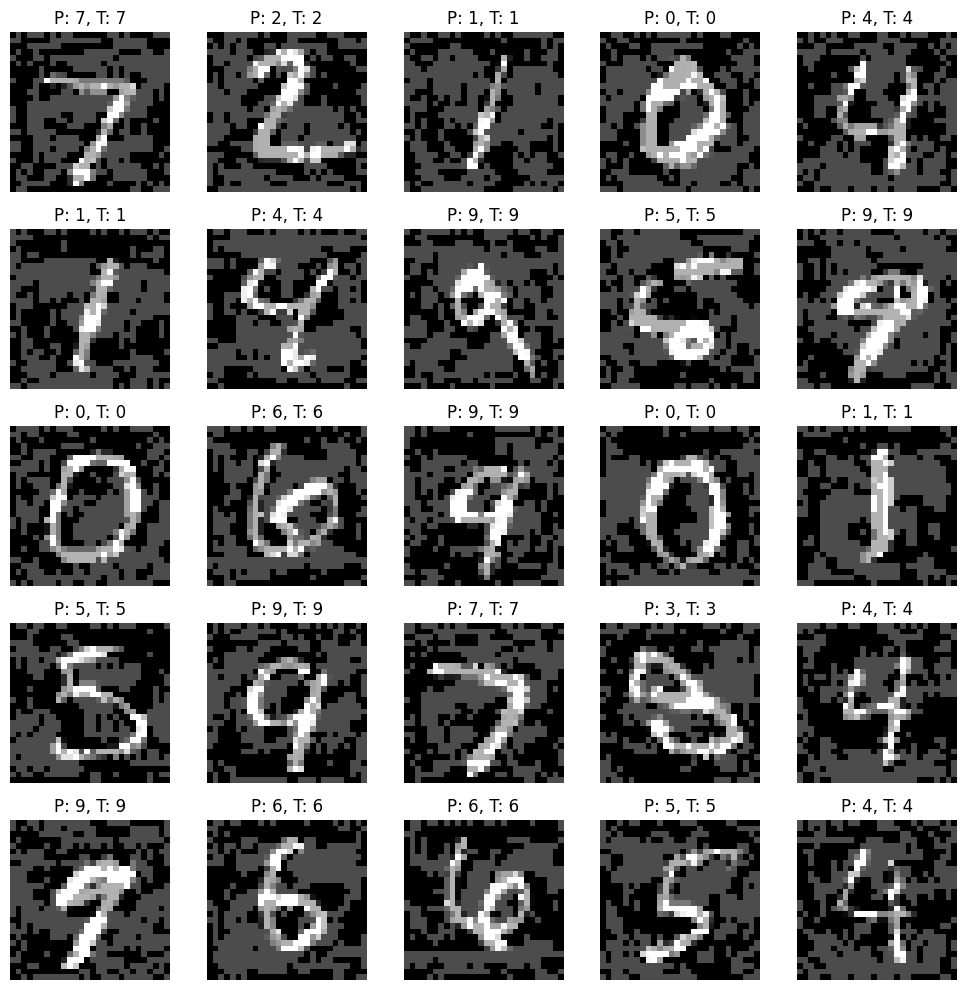

In [18]:
# Visualization adversarial images with corresponding predicted labels and true labels
num_images_to_plot = 25
subset_adv_images = all_adv_data[:num_images_to_plot]

_, predicted_labels = torch.max(model_adv(subset_adv_images.to(device)), 1)
titles = [f'P: {p.item()}, T: {t.item()}' for p, t in zip(predicted_labels, all_adv_labels[:num_images_to_plot])]


plot_adversarial_images(subset_adv_images, titles=titles)

In [19]:
_, predicted_labels = torch.max(model_adv(all_adv_data.to(device)), 1)
num_correct = 0
for x, y in zip(predicted_labels, all_adv_labels):
  if x == y:
    num_correct += 1
print(f'Accuracy on adversarial testing set AFTER training: {(num_correct / len(all_adv_data)) * 100}%')

Accuracy on adversarial testing set AFTER training: 99.1%


# Extension 3: Testing Trained Adversarial Model on OOD Attack

torch.Size([10000, 28, 28])


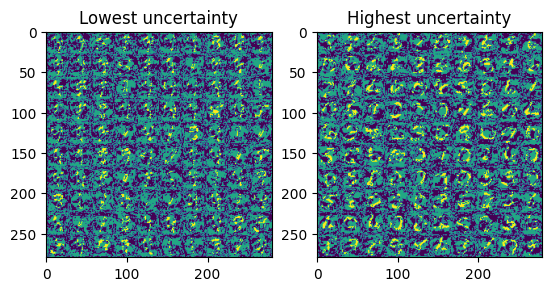

In [20]:
# Generate adversarial examples
adv_examples_test, adv_examples_train = generate_adversarial_examples(test_loader, train_loader, attack, fmodel, 0.6)
all_adv_data, all_adv_labels = concatenate_adv_examples(adv_examples_test)
all_adv_data_train, all_adv_labels_train = concatenate_adv_examples(adv_examples_train)

all_adv_data_train = all_adv_data_train.squeeze().cpu()
all_adv_labels_train = all_adv_labels_train.cpu()

all_adv_data = all_adv_data.squeeze().cpu()
all_adv_labels = all_adv_labels.cpu()

# Run predictions on the test set and compute uncertainty
y_test_pred, y_test_unc = predict_with_uncertainty(model_adv, all_adv_data.to(device), num_stochastic_samples=10)

y_test_pred = np.mean(y_test_pred, axis = 1)
y_test_unc = np.mean(y_test_unc, axis = 1)

inds_sorted_by_unc = np.argsort(y_test_unc)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(plot_grid(all_adv_data[inds_sorted_by_unc[:100]])); ax[0].set_title("Lowest uncertainty");
ax[1].imshow(plot_grid(all_adv_data[inds_sorted_by_unc[-100:]])); ax[1].set_title("Highest uncertainty");

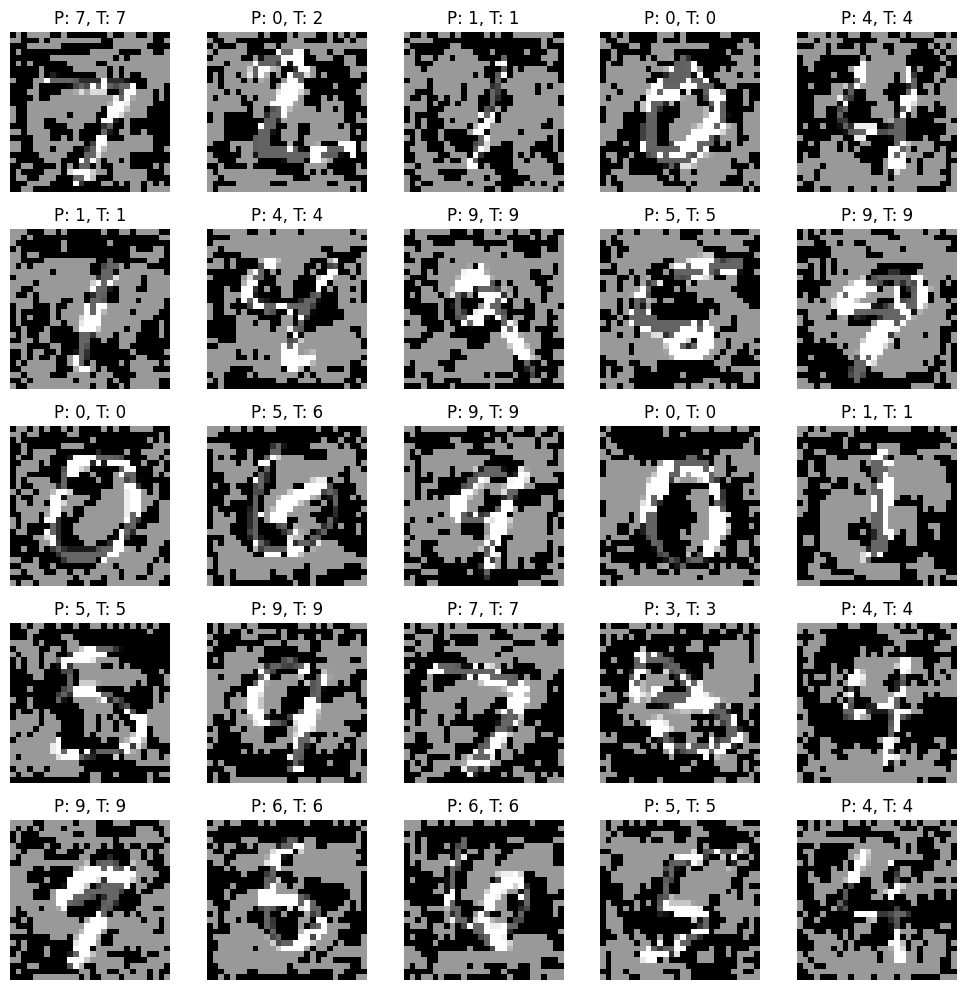

In [31]:
def plot_adversarial_images(images, titles=None, rows=5, cols=5, figsize=(10, 10)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        img = images[i].cpu().numpy().squeeze()
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        if titles is not None:
            ax.set_title(titles[i])

    plt.tight_layout()
    plt.show()

num_images_to_plot = 25
subset_adv_images = all_adv_data[:num_images_to_plot]

_, predicted_labels = torch.max(model_adv(subset_adv_images.to(device)), 1)
titles = [f'P: {p.item()}, T: {t.item()}' for p, t in zip(predicted_labels, all_adv_labels[:num_images_to_plot])]

plot_adversarial_images(subset_adv_images, titles=titles)

In [22]:
_, predicted_labels = torch.max(model_adv(all_adv_data.to(device)), 1)
num_correct = 0
for x, y in zip(predicted_labels, all_adv_labels):
  if x == y:
    num_correct += 1
print(f'Accuracy on  adversarial testing set without training: {(num_correct / len(all_adv_data)) * 100}%')

Accuracy on  adversarial testing set without training: 93.97999999999999%


As we can see, the accuracy of the adversarial model trained on $ϵ = 0.3$ still performs relatively fine on OOD inputs with more noise/perturbations added!

# Extension 4: Implementing training on continuous regression problems (e.g., MSE loss) rather than classification problems (e.g., cross entropy loss);

In [23]:
# REGRESSION DATASET
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

housing = fetch_california_housing()
x_full, y_full = housing['data'], housing['target']
x_train, x_test, y_train, y_test = train_test_split(x_full, y_full, test_size=1/7)
housing

{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]]),
 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]),
 'frame': None,
 'target_names': ['MedHouseVal'],
 'feature_names': ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 'DESCR': '.. _california_housing_dataset:\n

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def create_model_regression(LinearLayer):
    model = nn.Sequential(
        nn.Flatten(),
        LinearLayer(8, 128),
        nn.ReLU(),
        LinearLayer(128, 128),
        nn.ReLU(),
        LinearLayer(128, 1),  # Single output for regression
    )
    return model

def train_regression(model, x_train, y_train, x_test, y_test, epochs=10, batch_size=64, lr=0.005):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    num_iters = x_train.shape[0] // batch_size
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss() #MSE as opposed to BCE

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for iter in range(num_iters):
            i_start = iter * batch_size
            x_batch = x_train[i_start : i_start + batch_size].to(device)
            y_batch = y_train[i_start : i_start + batch_size].to(device)
            optimizer.zero_grad()
            y_pred = model(x_batch).squeeze()
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Evaluate on testing set
        model.eval()
        with torch.no_grad():
            x_test_device = x_test.to(device)
            y_test_device = y_test.to(device)  # Move y_test to the same device
            y_pred = model(x_test_device).squeeze().cpu()
            test_loss = loss_fn(y_pred, y_test_device.cpu())
        avg_loss = total_loss / num_iters
        print(f"epoch: {epoch}  ||  avg training loss: {avg_loss:.4f}  ||  test loss: {test_loss:.4f}")

    return model


In [27]:
# Create a new model now using our custom Dense Bayesian layers
model = create_model_regression(LinearLayer=LinearBayesian)
model.to(device)
print(model)
# ... and train it!
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)
x_test_tensor = torch.from_numpy(x_test).float().to(device)
y_test_tensor = torch.from_numpy(y_test).float().to(device)

model = train_regression(model, x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor)
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): LinearBayesian()
  (2): ReLU()
  (3): LinearBayesian()
  (4): ReLU()
  (5): LinearBayesian()
)
epoch: 0  ||  avg training loss: 962.8173  ||  test loss: 47.2417
epoch: 1  ||  avg training loss: 13.8892  ||  test loss: 22.2041
epoch: 2  ||  avg training loss: 7.5908  ||  test loss: 6.5605
epoch: 3  ||  avg training loss: 3.4431  ||  test loss: 3.9050
epoch: 4  ||  avg training loss: 2.1697  ||  test loss: 1.3935
epoch: 5  ||  avg training loss: 1.9177  ||  test loss: 2.0254
epoch: 6  ||  avg training loss: 1.7605  ||  test loss: 1.5569
epoch: 7  ||  avg training loss: 1.6412  ||  test loss: 1.7883
epoch: 8  ||  avg training loss: 1.4864  ||  test loss: 1.4715
epoch: 9  ||  avg training loss: 1.3495  ||  test loss: 0.9606


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): LinearBayesian()
  (2): ReLU()
  (3): LinearBayesian()
  (4): ReLU()
  (5): LinearBayesian()
)

In [28]:
def predict_with_uncertainty(model, inputs, num_stochastic_samples=10):
  """ Stochastically samples multiple forward passes through the network and
  compute the prediction and uncertainty of the model by taking the mean and
  standard deviation (respectively) over the sampled outputs. Remember to pass
  the sampled logits through a softmax before computing the mean and std.

  Returns a tuple of the estimated prediction (mean) and uncertainty (std)
  over the predicted probabilities. """
  model.eval()
  with torch.no_grad():
      """ TODO: evaluate `num_stochastic_samples` forward passes through the model """
      outputs = [model(inputs).cpu() for _ in range(num_stochastic_samples)]
      outputs = torch.stack(outputs).squeeze()  # Shape: [num_stochastic_samples, batch_size]
      """ TODO: compute the final prediction """
      prediction = tuple(torch.mean(outputs, dim = 0).tolist())  # Mean over samples; Shape: [number of samples,]
      """ TODO: compute the final uncertainty """
      uncertainty = tuple(torch.std(outputs, dim = 0).tolist())  # Standard deviation; Shape: [number of samples,]

  return prediction, uncertainty

MAE:0.7267558505338149


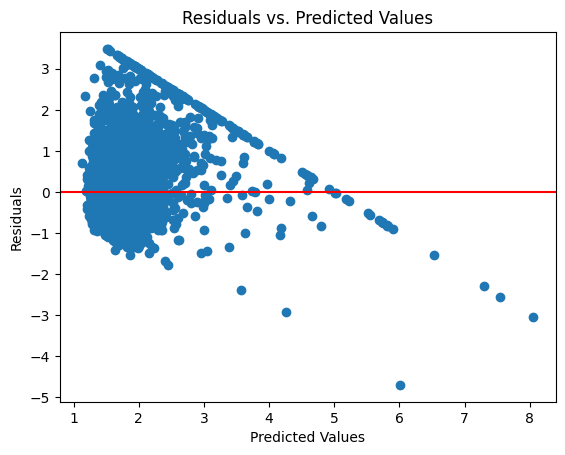

In [29]:
y_test_pred, y_test_unc = predict_with_uncertainty(model, x_test_tensor.to(device), num_stochastic_samples=10)


mae = mean_absolute_error(y_test, y_test_pred)
print("MAE:" + str(mae))

residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()


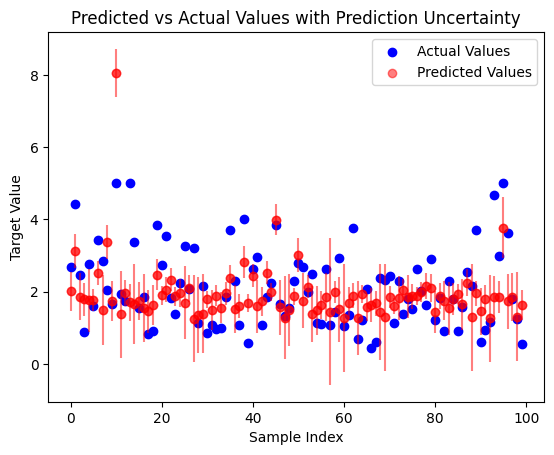

In [30]:
num_datapoints = 100

plt.scatter(range(len(y_test[:num_datapoints])), y_test[:num_datapoints], color='blue', label='Actual Values')

plt.scatter(range(len(y_test_pred[:num_datapoints])), y_test_pred[:num_datapoints], color='red', label='Predicted Values', alpha = 0.5)

plt.errorbar(range(len(y_test_pred[:num_datapoints])), y_test_pred[:num_datapoints], yerr=y_test_unc[:num_datapoints], fmt='o', color='red', alpha=0.5)

plt.title('Predicted vs Actual Values with Prediction Uncertainty')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.show()
